# 1. Hurst & Entropy

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc file CSV
df = pd.read_csv("../data/vn30/volume.csv")
df_close = pd.read_csv("../data/vn30/close.csv")

In [ ]:
import numpy as np
from scipy.stats import entropy
from hurst import compute_Hc
import antropy as ant
import pandas as pd

# Sử dụng df_close thay vì df để tính toán các chỉ số
# Lấy tất cả các cột chứng khoán (loại trừ cột 'time' nếu có)
stock_columns = [col for col in df_close.columns if col != 'time']

# Khởi tạo danh sách lưu kết quả
results = []

# Xử lý từng cột chứng khoán
for stock in stock_columns:
    try:
        # Lấy dữ liệu giá đóng cửa cho cổ phiếu hiện tại và loại bỏ giá trị NaN
        data = df_close[stock].dropna().values
        
        if len(data) > 0:
            # Thay thế giá trị 0 bằng một giá trị nhỏ để tránh lỗi log(0)
            data_no_zeros = np.where(data == 0, 1e-10, data)
            
            # Tính chỉ số Hurst với dữ liệu giá đóng cửa
            # Sử dụng kind='returns' thay vì 'price' để phân tích lợi nhuận
            # Tính returns trước khi tính Hurst
            returns = np.diff(np.log(data_no_zeros))
            if len(returns) >= 100:  # Đảm bảo có đủ dữ liệu để tính Hurst chính xác
                H, c, data_hurst = compute_Hc(returns, kind='random_walk', simplified=True)
            else:
                H = np.nan
                print(f"Không đủ dữ liệu cho {stock} để tính Hurst (cần ít nhất 100 điểm)")
            
            # Tính Approximate Entropy (ApEn)
            if len(data_no_zeros) >= 10:  # Đảm bảo có đủ dữ liệu
                ApEn = ant.app_entropy(data_no_zeros, order=2)
                
                # Tính Sample Entropy (SampEn)
                SampEn = ant.sample_entropy(data_no_zeros, order=2)
                
                # Tính Permutation Entropy
                PermEn = ant.perm_entropy(data_no_zeros, order=3, normalize=True)
            else:
                ApEn = SampEn = PermEn = np.nan
                print(f"Không đủ dữ liệu cho {stock} để tính Entropy")
            
            # Lưu kết quả
            results.append({
                "Stock": stock,
                "Hurst Exponent": H,
                "Approximate Entropy": ApEn,
                "Sample Entropy": SampEn,
                "Permutation Entropy": PermEn
            })
        else:
            print(f"Không có dữ liệu hợp lệ cho {stock}")
    except Exception as e:
        print(f"Lỗi khi xử lý {stock}: {e}")

# Chuyển đổi kết quả thành DataFrame để phân tích dễ dàng hơn
results_df = pd.DataFrame(results)

# Kiểm tra và lọc các giá trị không hợp lệ
results_df = results_df.dropna().reset_index(drop=True)

# Kiểm tra giá trị Hurst không hợp lệ (>1 hoặc <0)
invalid_hurst = results_df[(results_df["Hurst Exponent"] > 1) | (results_df["Hurst Exponent"] < 0)]
if not invalid_hurst.empty:
    print(f"Cảnh báo: Có {len(invalid_hurst)} cổ phiếu có giá trị Hurst không hợp lệ (>1 hoặc <0)")
    print(invalid_hurst[["Stock", "Hurst Exponent"]])
    # Loại bỏ các giá trị Hurst không hợp lệ
    results_df = results_df[(results_df["Hurst Exponent"] <= 1) & (results_df["Hurst Exponent"] >= 0)]

# Sắp xếp theo tên cổ phiếu để dễ đọc
results_df = results_df.sort_values("Stock").reset_index(drop=True)

# Tính toán thống kê để đưa ra insights
stats_df = pd.DataFrame({
    "Mean": results_df.mean(numeric_only=True),
    "Median": results_df.median(numeric_only=True),
    "Min": results_df.min(numeric_only=True),
    "Max": results_df.max(numeric_only=True),
    "Std": results_df.std(numeric_only=True)
}).T

# Hiển thị bảng kết quả
print("Kết quả cho từng cổ phiếu:")
print(results_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

print("\nThống kê tổng quan:")
print(stats_df.to_string(float_format=lambda x: f"{x:.4f}"))

# Phân nhóm cổ phiếu theo đặc tính Hurst
hurst_groups = {
    "Random Walk (0.45 < H < 0.55)": results_df[(results_df["Hurst Exponent"] > 0.45) & (results_df["Hurst Exponent"] < 0.55)]["Stock"].tolist(),
    "Anti-persistent (H ≤ 0.45)": results_df[results_df["Hurst Exponent"] <= 0.45]["Stock"].tolist(),
    "Persistent (H ≥ 0.55)": results_df[results_df["Hurst Exponent"] >= 0.55]["Stock"].tolist()
}

print("\nPhân tích dựa trên chỉ số Hurst:")
for category, stocks in hurst_groups.items():
    print(f"{category}: {', '.join(stocks) if stocks else 'Không có'}")

# Xác định cổ phiếu có giá trị entropy cao nhất/thấp nhất
print("\nCổ phiếu có giá trị entropy đặc biệt:")
metrics = ["Approximate Entropy", "Sample Entropy", "Permutation Entropy"]
for metric in metrics:
    highest = results_df.loc[results_df[metric].idxmax()]
    lowest = results_df.loc[results_df[metric].idxmin()]
    print(f"Cao nhất {metric}: {highest['Stock']} ({highest[metric]:.4f})")
    print(f"Thấp nhất {metric}: {lowest['Stock']} ({lowest[metric]:.4f})")

# Phân tích tổng quan thị trường
avg_hurst = stats_df.loc["Mean", "Hurst Exponent"]
print("\nPhân tích tổng quan thị trường:")
if avg_hurst > 0.55:
    print(f"- Thị trường thể hiện xu hướng bền vững (Hurst trung bình = {avg_hurst:.4f}), gợi ý các mẫu có xu hướng")
elif avg_hurst < 0.45:
    print(f"- Thị trường thể hiện xu hướng đảo chiều về giá trị trung bình (Hurst trung bình = {avg_hurst:.4f}), gợi ý các mẫu có tính quay về giá trị trung bình")
else:
    print(f"- Thị trường thể hiện đặc tính đi ngẫu nhiên (Hurst trung bình = {avg_hurst:.4f}), gợi ý định giá hiệu quả")

# Tương quan giữa các chỉ số
correlation = results_df.iloc[:, 1:].corr()
print("\nTương quan giữa các chỉ số:")
print(correlation.to_string(float_format=lambda x: f"{x:.4f}"))

# Phân tích thêm dựa trên các chỉ số entropy
avg_apen = stats_df.loc["Mean", "Approximate Entropy"]
avg_sampen = stats_df.loc["Mean", "Sample Entropy"]
avg_permen = stats_df.loc["Mean", "Permutation Entropy"]

print("\nPhân tích thêm:")
print(f"- Approximate Entropy trung bình: {avg_apen:.4f}")
print(f"- Sample Entropy trung bình: {avg_sampen:.4f}")
print(f"- Permutation Entropy trung bình: {avg_permen:.4f}")
print("- Giá trị entropy cao hơn chỉ ra tính ngẫu nhiên nhiều hơn và khả năng dự đoán thấp hơn")
print("- Giá trị entropy thấp hơn chỉ ra cấu trúc nhiều hơn và khả năng dự đoán cao hơn")

# Xác định các mẫu đáng chú ý hoặc ngoại lệ
outliers = []
for metric in ["Hurst Exponent", "Approximate Entropy", "Sample Entropy", "Permutation Entropy"]:
    mean = stats_df.loc["Mean", metric]
    std = stats_df.loc["Std", metric]
    high_outliers = results_df[results_df[metric] > mean + 2*std]["Stock"].tolist()
    low_outliers = results_df[results_df[metric] < mean - 2*std]["Stock"].tolist()
    
    if high_outliers:
        outliers.append(f"Cao bất thường trong {metric}: {', '.join(high_outliers)}")
    if low_outliers:
        outliers.append(f"Thấp bất thường trong {metric}: {', '.join(low_outliers)}")

if outliers:
    print("\nCác ngoại lệ đáng chú ý (vượt quá 2 độ lệch chuẩn):")
    for outlier in outliers:
        print(f"- {outlier}")

Kết quả cho từng cổ phiếu:
Stock  Hurst Exponent  Approximate Entropy  Sample Entropy  Permutation Entropy
  ACB          0.2267               0.1383          0.1166               0.9478
  BCM          0.2290               0.1955          0.1601               0.9508
  BID          0.1268               0.2827          0.2254               0.9708
  BVH          0.1432               0.5888          0.4306               0.9530
  CTG          0.1213               0.2538          0.1978               0.9707
  FPT          0.1862               0.0590          0.0409               0.9531
  GAS          0.1494               0.3688          0.2492               0.9620
  GVR          0.1250               0.2267          0.1832               0.9525
  HDB          0.1453               0.1384          0.1236               0.9484
  HPG          0.1314               0.1633          0.1353               0.9610
  LPB          0.2188               0.0876          0.0739               0.9200
  MBB        

C:\Users\admin\AppData\Local\Temp\ipykernel_28104\1842048732.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_hurst.set_xticklabels(df_metrics["Stock"], rotation=45, ha="right")


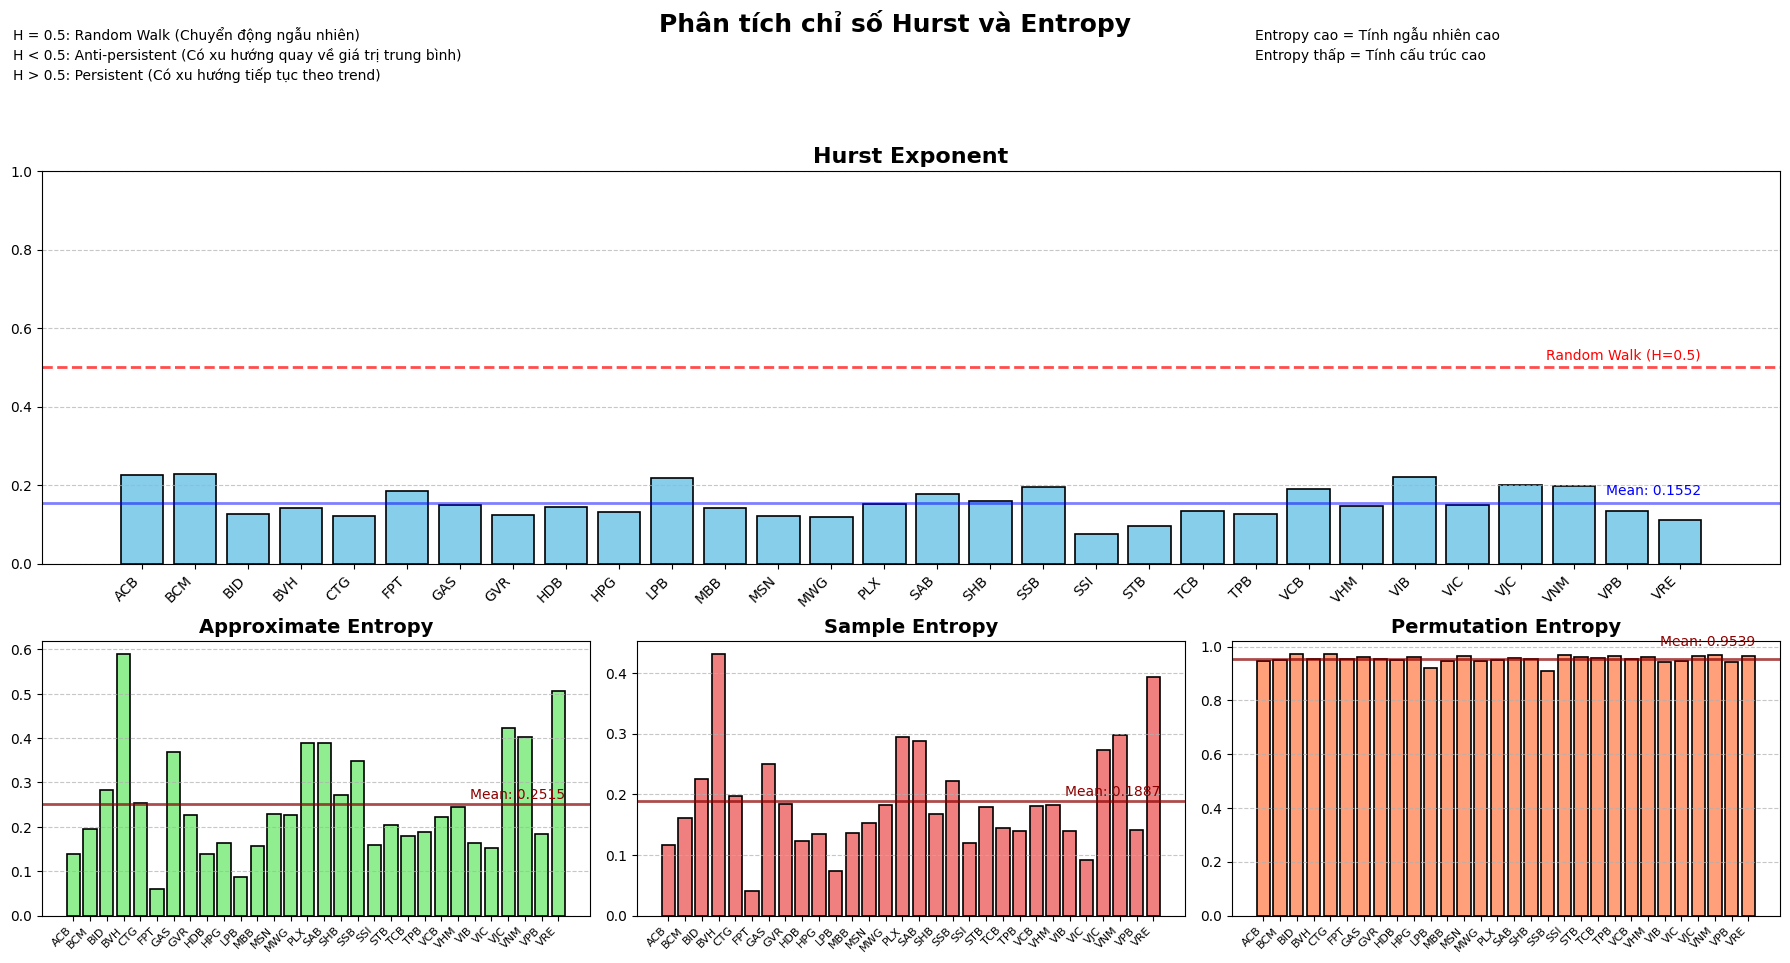

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Giả sử df_metrics đã được tạo từ results_df
df_metrics = pd.DataFrame(results_df)

# Tạo figure với kích thước tùy chỉnh
fig = plt.figure(figsize=(18, 10))

# Tạo GridSpec với 2 hàng:
# - Hàng 1: Hurst Exponent (cao 1, dài 6)
# - Hàng 2: 3 entropy (cao 1, mỗi cái dài 2)
gs = gridspec.GridSpec(2, 6, height_ratios=[1, 1])

# Tiêu đề chính
fig.suptitle("Phân tích chỉ số Hurst và Entropy", fontsize=18, fontweight="bold")

# Biểu đồ Hurst Exponent (hàng trên, chiếm tất cả 6 cột)
ax_hurst = fig.add_subplot(gs[0, :])
bars_hurst = ax_hurst.bar(df_metrics["Stock"], df_metrics["Hurst Exponent"], 
                         color="skyblue", edgecolor='black', linewidth=1.2)
ax_hurst.set_title("Hurst Exponent", fontsize=16, fontweight="bold")
ax_hurst.set_ylim(0, 1)  # Giới hạn y từ 0 đến 1 (giá trị hợp lệ của Hurst)

# Vẽ đường Random Walk tại H=0.5
ax_hurst.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, linewidth=2)
ax_hurst.text(len(df_metrics["Stock"])*0.98, 0.52, "Random Walk (H=0.5)", 
             color='r', ha="right", fontsize=10)

# Vẽ đường trung bình cho Hurst
mean_hurst = df_metrics["Hurst Exponent"].mean()
ax_hurst.axhline(y=mean_hurst, color='blue', linestyle='-', alpha=0.5, linewidth=2)
ax_hurst.text(len(df_metrics["Stock"])*0.98, mean_hurst+0.02, f"Mean: {mean_hurst:.4f}", 
             color='blue', ha="right", fontsize=10)

ax_hurst.grid(axis="y", linestyle="--", alpha=0.7)
ax_hurst.set_xticklabels(df_metrics["Stock"], rotation=45, ha="right")

# Thêm 3 entropy vào hàng dưới (mỗi cái chiếm 2 cột)
entropy_metrics = ["Approximate Entropy", "Sample Entropy", "Permutation Entropy"]
colors = ["lightgreen", "lightcoral", "lightsalmon"]
positions = [(1, 0), (1, 2), (1, 4)]  # Vị trí bắt đầu cho mỗi biểu đồ entropy

for i, (metric, color, pos) in enumerate(zip(entropy_metrics, colors, positions)):
    # Mỗi biểu đồ entropy chiếm 2 cột
    ax = fig.add_subplot(gs[pos[0], pos[1]:pos[1]+2])
    bars = ax.bar(df_metrics["Stock"], df_metrics[metric], 
                 color=color, edgecolor='black', linewidth=1.2)
    ax.set_title(metric, fontsize=14, fontweight="bold")
    
    # Thêm đường trung bình
    mean_value = df_metrics[metric].mean()
    ax.axhline(y=mean_value, color='darkred', linestyle='-', alpha=0.7, linewidth=2)
    ax.text(len(df_metrics["Stock"])*0.98, mean_value*1.05, f"Mean: {mean_value:.4f}", 
           color='darkred', ha="right", fontsize=10)
    
    # Thiết lập tỉ lệ cao 1:dài 2 bằng cách điều chỉnh tỉ lệ khung hình
    ax.set_box_aspect(0.5)  # Chiều cao bằng 1/2 chiều rộng (tỉ lệ 1:2)
    
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.set_xticks(range(len(df_metrics["Stock"])))
    ax.set_xticklabels(df_metrics["Stock"], rotation=45, ha="right", fontsize=8)

# Thêm ghi chú giải thích về Hurst Exponent
fig.text(0.01, 0.95, "H = 0.5: Random Walk (Chuyển động ngẫu nhiên)", fontsize=10)
fig.text(0.01, 0.93, "H < 0.5: Anti-persistent (Có xu hướng quay về giá trị trung bình)", fontsize=10)
fig.text(0.01, 0.91, "H > 0.5: Persistent (Có xu hướng tiếp tục theo trend)", fontsize=10)

# Thêm ghi chú giải thích về Entropy
fig.text(0.7, 0.95, "Entropy cao = Tính ngẫu nhiên cao", fontsize=10)
fig.text(0.7, 0.93, "Entropy thấp = Tính cấu trúc cao", fontsize=10)

# Điều chỉnh khoảng cách
plt.tight_layout(rect=[0, 0, 1, 0.9])

# Hiển thị biểu đồ
plt.show()

In [19]:
import numpy as np
import pandas as pd

# Lấy tất cả các cột chứng khoán (loại trừ cột 'time')
stock_columns = [col for col in df.columns if col != 'time']

# Khởi tạo danh sách lưu kết quả
results = []

def create_recurrence_matrix(data, threshold=0.1):
    """
    Tạo ma trận tái phát từ chuỗi thời gian
    
    Parameters:
    data (array): Chuỗi thời gian
    threshold (float): Ngưỡng khoảng cách để xác định điểm tái phát
    
    Returns:
    array: Ma trận tái phát (1 = tái phát, 0 = không tái phát)
    """
    n = len(data)
    # Chuẩn hóa dữ liệu để đảm bảo phạm vi so sánh nhất quán
    data_norm = (data - np.min(data)) / (np.max(data) - np.min(data) + 1e-10)
    
    # Tạo ma trận tái phát sử dụng vectorization để tăng hiệu suất
    distance = np.abs(data_norm.reshape(n, 1) - data_norm.reshape(1, n))
    return (distance < threshold).astype(int)

def compute_rr(data, threshold=0.1):
    """
    Tính Recurrence Rate (RR) - Tỷ lệ tái phát
    
    RR đo lường % các điểm dữ liệu có giá trị tương tự nhau.
    RR cao -> dữ liệu có tính chu kỳ/lặp lại cao
    RR thấp -> dữ liệu ít chu kỳ/nhiễu
    
    Returns:
    float: Giá trị từ 0 đến 1
    """
    if len(data) <= 1:
        return 0
    
    # Tạo ma trận tái phát
    rm = create_recurrence_matrix(data, threshold)
    
    # RR là tỷ lệ các điểm tái phát trên tổng số điểm
    return np.sum(rm) / (len(data) ** 2)

def compute_det(data, threshold=0.1, min_diagonal=2):
    """
    Tính Determinism (DET) - Độ xác định/dự đoán
    
    DET đo lường % các điểm tái phát thuộc các đường chéo có độ dài >= min_diagonal.
    DET cao -> hệ thống có tính dự đoán cao, quỹ đạo ổn định
    DET thấp -> hệ thống hỗn loạn, khó dự đoán
    
    Returns:
    float: Giá trị từ 0 đến 1
    """
    if len(data) <= min_diagonal:
        return 0
    
    # Tạo ma trận tái phát
    rm = create_recurrence_matrix(data, threshold)
    n = len(data)
    
    # Tính tổng các điểm tái phát nằm trên các đường chéo có độ dài >= min_diagonal
    diagonal_points = 0
    total_points = np.sum(rm)
    
    if total_points == 0:
        return 0
    
    # Kiểm tra các đường chéo song song với đường chéo chính
    for diag in range(-n+min_diagonal, n-min_diagonal+1):
        diagonal = np.diagonal(rm, offset=diag)
        # Tìm độ dài của các đoạn liên tiếp giá trị 1
        chunks = [len(list(g)) for k, g in itertools.groupby(diagonal) if k == 1]
        # Chỉ tính các đoạn có độ dài >= min_diagonal
        diagonal_points += sum(length for length in chunks if length >= min_diagonal)
    
    # DET là tỷ lệ điểm tái phát nằm trên đường chéo có độ dài >= min_diagonal
    return min(1.0, diagonal_points / total_points) if total_points > 0 else 0

def compute_lam(data, threshold=0.1, min_vertical=2):
    """
    Tính Laminarity (LAM) - Độ ổn định
    
    LAM đo lường % các điểm tái phát thuộc các đường thẳng đứng có độ dài >= min_vertical.
    LAM cao -> hệ thống có xu hướng duy trì trạng thái, ít biến động
    LAM thấp -> hệ thống không ổn định, nhiều biến động
    
    Returns:
    float: Giá trị từ 0 đến 1
    """
    if len(data) <= min_vertical:
        return 0
    
    # Tạo ma trận tái phát
    rm = create_recurrence_matrix(data, threshold)
    n = len(data)
    
    # Tính các đường thẳng đứng
    vertical_points = 0
    total_points = np.sum(rm)
    
    if total_points == 0:
        return 0
    
    # Tìm các đoạn thẳng đứng liên tiếp
    for col in range(n):
        column = rm[:, col]
        # Tìm độ dài của các đoạn liên tiếp giá trị 1
        chunks = [len(list(g)) for k, g in itertools.groupby(column) if k == 1]
        # Chỉ tính các đoạn có độ dài >= min_vertical
        vertical_points += sum(length for length in chunks if length >= min_vertical)
    
    # LAM là tỷ lệ điểm tái phát nằm trên đường thẳng đứng có độ dài >= min_vertical
    return min(1.0, vertical_points / total_points) if total_points > 0 else 0

def compute_tt(data, threshold=0.1, min_vertical=2):
    """
    Tính Trapping Time (TT) - Thời gian bẫy
    
    TT đo lường thời gian trung bình hệ thống duy trì ở một trạng thái nhất định.
    TT được chuẩn hóa bằng công thức sigmoid để đảm bảo nằm trong khoảng [0, 1].
    TT gần 1 -> hệ thống có xu hướng "mắc kẹt" ở trạng thái, khó thay đổi
    TT gần 0 -> hệ thống thay đổi trạng thái nhanh chóng
    
    Returns:
    float: Giá trị từ 0 đến 1 (được chuẩn hóa)
    """
    if len(data) <= min_vertical:
        return 0
    
    # Tạo ma trận tái phát
    rm = create_recurrence_matrix(data, threshold)
    n = len(data)
    
    # Tìm độ dài trung bình của các đường thẳng đứng
    vertical_lengths = []
    
    for col in range(n):
        column = rm[:, col]
        # Tìm độ dài của các đoạn liên tiếp giá trị 1
        chunks = [len(list(g)) for k, g in itertools.groupby(column) if k == 1]
        # Chỉ tính các đoạn có độ dài >= min_vertical
        vertical_lengths.extend([length for length in chunks if length >= min_vertical])
    
    if not vertical_lengths:
        return 0
    
    # Tính trung bình độ dài đường thẳng đứng
    avg_length = np.mean(vertical_lengths)
    
    # Chuẩn hóa bằng hàm sigmoid để đảm bảo kết quả nằm trong khoảng [0, 1]
    # Tham số k điều chỉnh độ dốc của sigmoid, tham số x0 điều chỉnh điểm giữa
    k = 0.5  # Có thể điều chỉnh để thay đổi độ nhạy
    x0 = 10  # Điểm trung bình - có thể điều chỉnh dựa vào đặc điểm dữ liệu
    
    return 1 / (1 + np.exp(-k * (avg_length - x0)))

import itertools  # Thêm thư viện cần thiết

# Xử lý từng cột chứng khoán
for stock in stock_columns:
    try:
        data = df[stock].dropna().values
        
        if len(data) > 0:
            # Thay thế giá trị 0 bằng một giá trị nhỏ để tránh lỗi
            data_no_zeros = np.where(data == 0, 1e-10, data)
            
            # Tính các chỉ số cải tiến
            rr = compute_rr(data_no_zeros)
            det = compute_det(data_no_zeros)
            lam = compute_lam(data_no_zeros)
            tt = compute_tt(data_no_zeros)
            
            # Lưu kết quả
            results.append({
                "Stock": stock,
                "Recurrence Rate (RR)": rr,
                "Determinism (DET)": det,
                "Laminarity (LAM)": lam,
                "Trapping Time (TT)": tt
            })
        else:
            print(f"Không có dữ liệu hợp lệ cho {stock}")
    except Exception as e:
        print(f"Lỗi khi xử lý {stock}: {e}")

# Tạo DataFrame kết quả và sắp xếp
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("Stock").reset_index(drop=True)

# Tính các thống kê cơ bản
stats_df = pd.DataFrame({
    "Mean": results_df.mean(numeric_only=True),
    "Median": results_df.median(numeric_only=True),
    "Min": results_df.min(numeric_only=True),
    "Max": results_df.max(numeric_only=True),
    "Std": results_df.std(numeric_only=True)
}).T

# Hiển thị bảng kết quả
print("Kết quả các chỉ số theo cổ phiếu:")
print(results_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

print("\nThống kê tổng quan:")
print(stats_df.to_string(float_format=lambda x: f"{x:.4f}"))

Kết quả các chỉ số theo cổ phiếu:
Stock  Recurrence Rate (RR)  Determinism (DET)  Laminarity (LAM)  Trapping Time (TT)
  ACB                0.5016             0.8370            0.8907              0.1312
  BCM                0.5565             0.9211            0.9483              0.8782
  BID                0.6598             0.9229            0.9447              0.4423
  BVH                0.4813             0.8297            0.8824              0.1092
  CTG                0.4488             0.8159            0.8698              0.1226
  FPT                0.5723             0.8915            0.9238              0.1918
  GAS                0.5254             0.8556            0.9013              0.1589
  GVR                0.4852             0.8306            0.8845              0.1341
  HDB                0.4129             0.8641            0.9099              0.2627
  HPG                0.5240             0.8317            0.8817              0.0862
  LPB                0.5273    

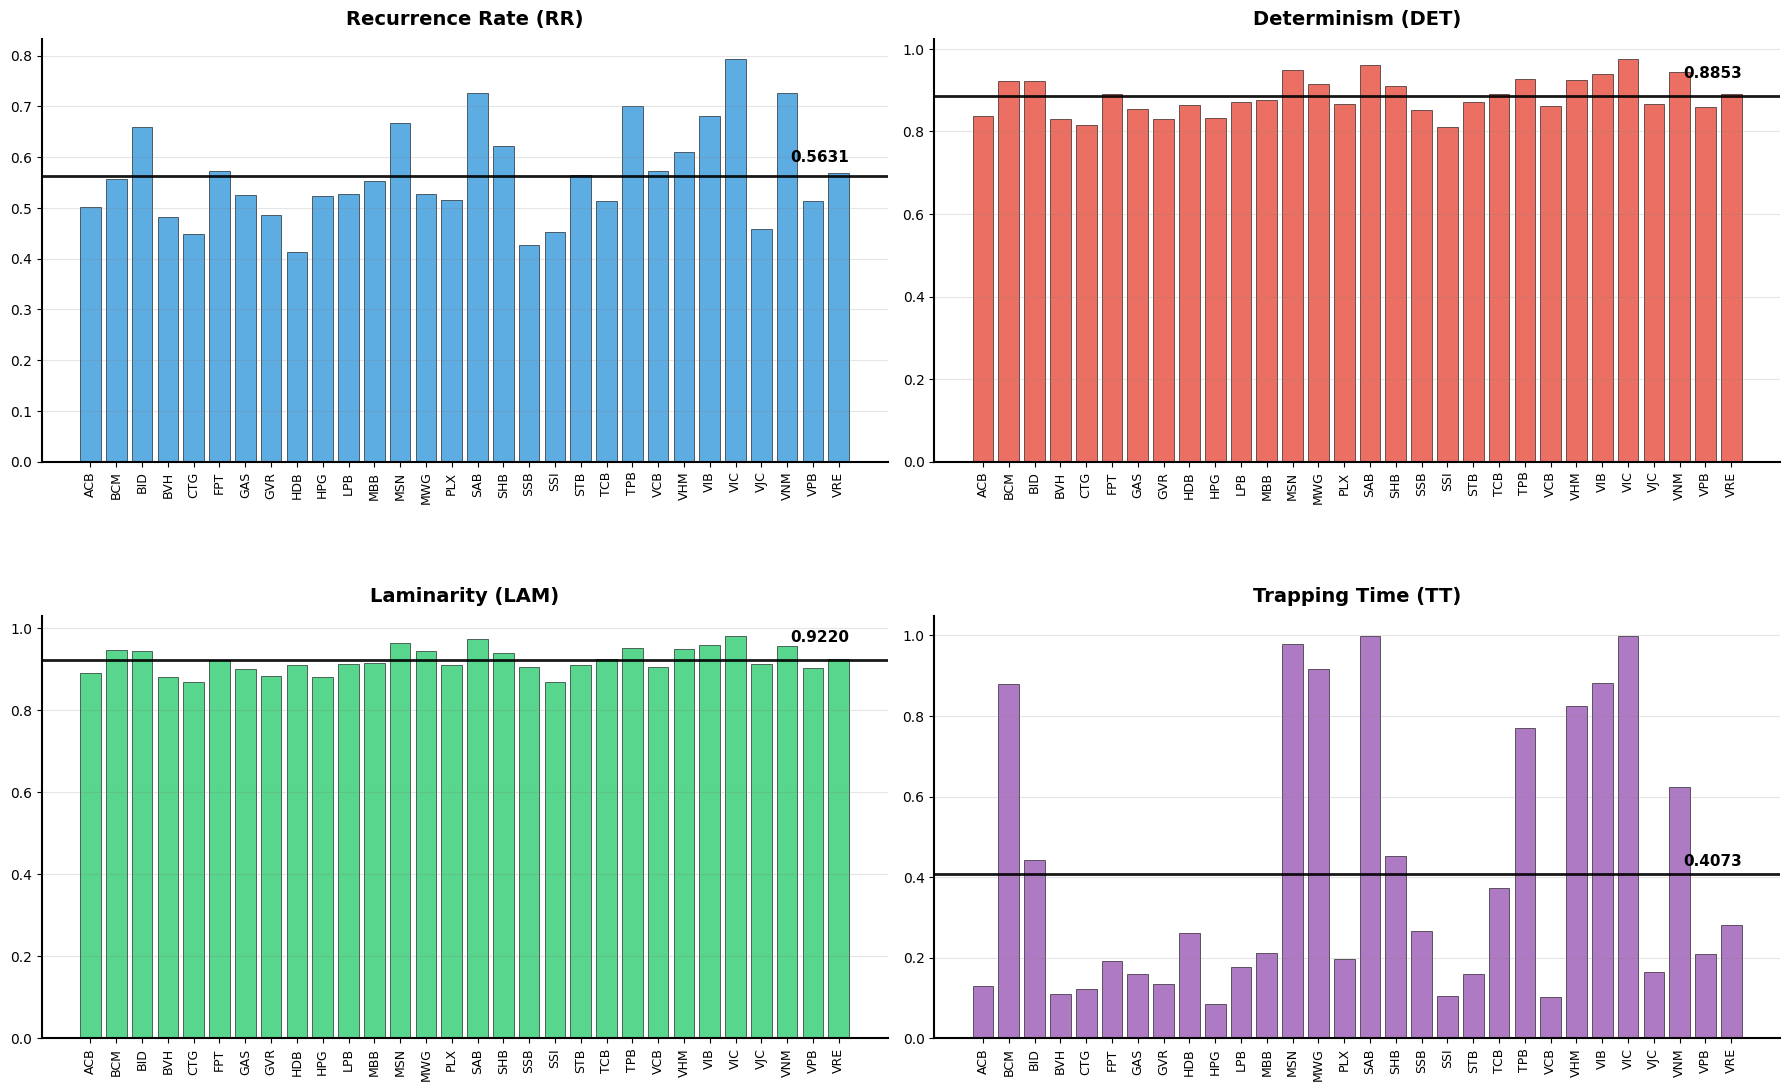

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Giả sử df_metrics đã được tạo từ results_df
df_metrics = results_df[["Stock", "Recurrence Rate (RR)", "Determinism (DET)", "Laminarity (LAM)", "Trapping Time (TT)"]]

# Tính giá trị trung bình cho từng chỉ số
mean_values = df_metrics.mean(numeric_only=True)

# Tạo figure với kích thước tùy chỉnh
fig = plt.figure(figsize=(18, 12))

# Tạo GridSpec với 2 hàng, 2 cột
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])

# Chọn bảng màu đẹp và rõ nét hơn
colors = ["#3498db", "#e74c3c", "#2ecc71", "#9b59b6"]  # Blue, Red, Green, Purple

# Danh sách các chỉ số
metrics = ["Recurrence Rate (RR)", "Determinism (DET)", "Laminarity (LAM)", "Trapping Time (TT)"]

# Vị trí cho mỗi biểu đồ
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

# Vẽ từng biểu đồ
for i, (metric, color, pos) in enumerate(zip(metrics, colors, positions)):
    ax = fig.add_subplot(gs[pos])
    
    # Vẽ biểu đồ cột với màu đậm và rõ nét
    bars = ax.bar(df_metrics["Stock"], df_metrics[metric], 
                 color=color, edgecolor='black', linewidth=0.5, alpha=0.8)
    
    # Thêm đường trung bình
    mean_value = mean_values[metric]
    ax.axhline(y=mean_value, color='black', linestyle='-', alpha=0.9, linewidth=2)
    ax.text(len(df_metrics["Stock"])*0.98, mean_value*1.05, f"{mean_value:.4f}", 
           color='black', ha="right", fontsize=11, fontweight='bold')
    
    # Thiết lập tỉ lệ cao 1:dài 2
    ax.set_box_aspect(0.5)  # Chiều cao bằng 1/2 chiều rộng (tỉ lệ 1:2)
    
    # Thêm tiêu đề và định dạng
    ax.set_title(metric, fontsize=14, fontweight="bold", pad=10)
    ax.grid(axis="y", linestyle="-", alpha=0.2, color='gray')
    ax.set_xticks(range(len(df_metrics["Stock"])))
    ax.set_xticklabels(df_metrics["Stock"], rotation=90, ha="center", fontsize=9)
    
    # Làm cho trục y rõ ràng hơn
    ax.tick_params(axis='y', labelsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Làm nổi bật viền biểu đồ
    for spine in ['bottom', 'left']:
        ax.spines[spine].set_linewidth(1.5)
        ax.spines[spine].set_color('black')

# Điều chỉnh khoảng cách
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

In [41]:
import pandas as pd
import numpy as np
from scipy import stats

# Đọc dữ liệu từ file CSV
high_df = pd.read_csv('../data/2024/high.csv')
low_df = pd.read_csv('../data/2024/low.csv')

# Lấy danh sách các công ty (tất cả các cột trừ cột 'time')
companies = [col for col in high_df.columns if col != 'time']

# Khởi tạo dictionary để lưu kết quả
results = {'company': companies}
weekly_irvs = []
monthly_irvs = []
rcis = []
srs = []
krs = []

# Xử lý từng công ty
for company in companies:
    # Tính Chỉ số Dao Động Nội Ngày (IR): giá cao - giá thấp
    IR = high_df[company] - low_df[company]
    
    # Tính Chỉ số Dao Động Nội Ngày Chuẩn Hóa (NIR): IR / (giá cao + giá thấp)
    NIR = IR / (high_df[company] + low_df[company])
    
    # Chuyển đổi thời gian sang định dạng datetime để nhóm
    time_datetime = pd.to_datetime(high_df['time'])
    
    # Tạo DataFrame với thời gian và IR để tính toán
    ir_df = pd.DataFrame({'time': time_datetime, 'IR': IR})
    
    # Thêm cột tuần và tháng
    ir_df['week'] = ir_df['time'].dt.isocalendar().week
    ir_df['year'] = ir_df['time'].dt.year
    ir_df['month'] = ir_df['time'].dt.month
    
    # Tính IRV theo tuần (độ lệch chuẩn của IR theo tuần)
    weekly_groups = ir_df.groupby(['year', 'week'])
    weekly_irv = weekly_groups['IR'].std().mean()
    weekly_irvs.append(weekly_irv)
    
    # Tính IRV theo tháng (độ lệch chuẩn của IR theo tháng)
    monthly_groups = ir_df.groupby(['year', 'month'])
    monthly_irv = monthly_groups['IR'].std().mean()
    monthly_irvs.append(monthly_irv)
    
    # Tính Chỉ số Ổn Định Dao Động (RCI): trung vị IR / trung bình IR
    mean_ir = IR.mean()
    median_ir = IR.median()
    RCI = median_ir / mean_ir if mean_ir != 0 else np.nan
    rcis.append(RCI)
    
    # Tính Chỉ số Độ Méo (SR): độ méo của phân bố IR
    SR = stats.skew(IR.dropna())
    srs.append(SR)
    
    # Tính Chỉ số Nhọn (KR): độ nhọn của phân bố IR
    KR = stats.kurtosis(IR.dropna())
    krs.append(KR)

# Thêm tất cả các chỉ số vào kết quả
results['Weekly_IRV'] = weekly_irvs
results['Monthly_IRV'] = monthly_irvs
results['RCI'] = rcis
results['SR'] = srs
results['KR'] = krs

# Tạo DataFrame từ kết quả
results_df = pd.DataFrame(results)

# Lưu vào file CSV
results_df.to_csv('stock_metrics.csv', index=False)

Đã tạo các biểu đồ trực quan hóa!


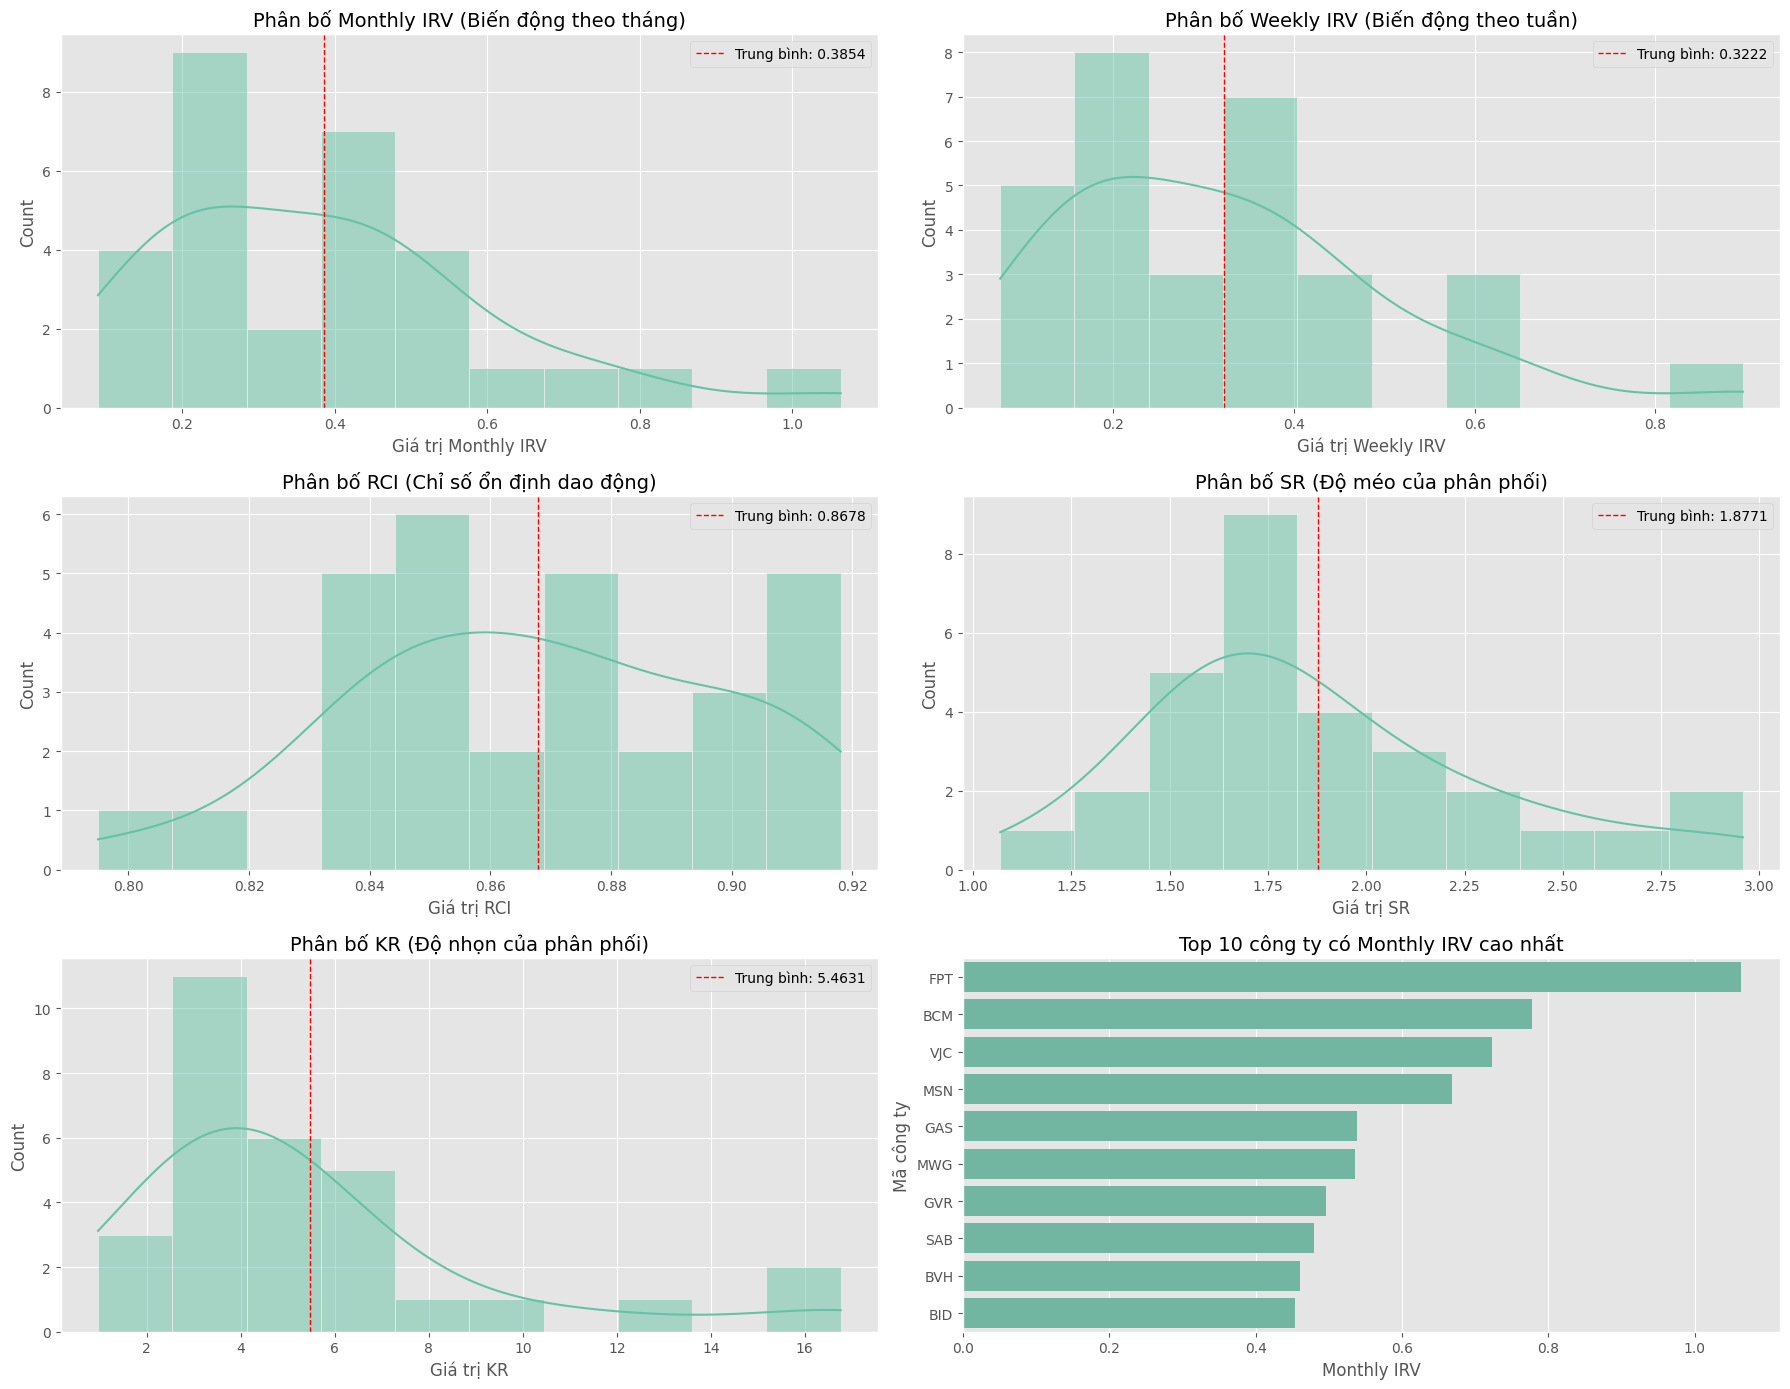

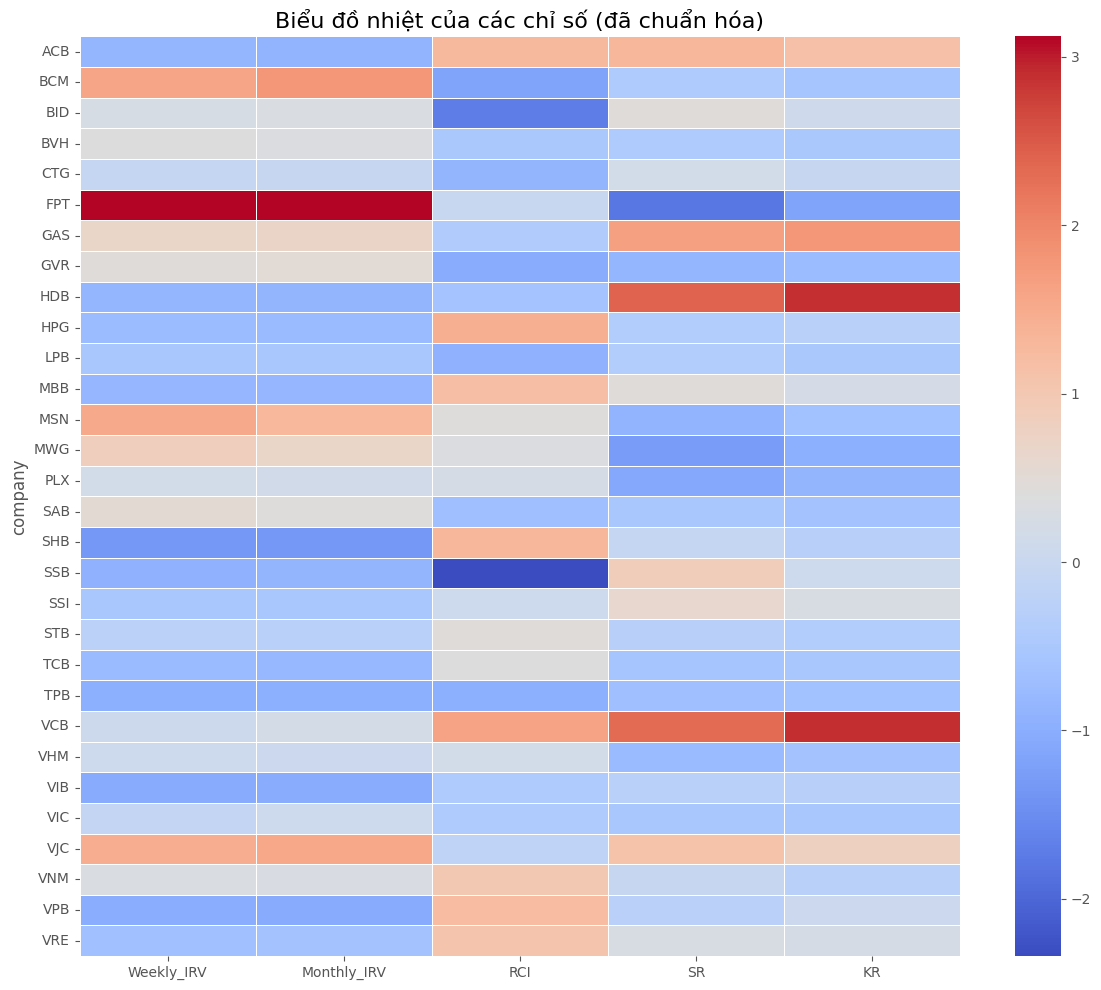

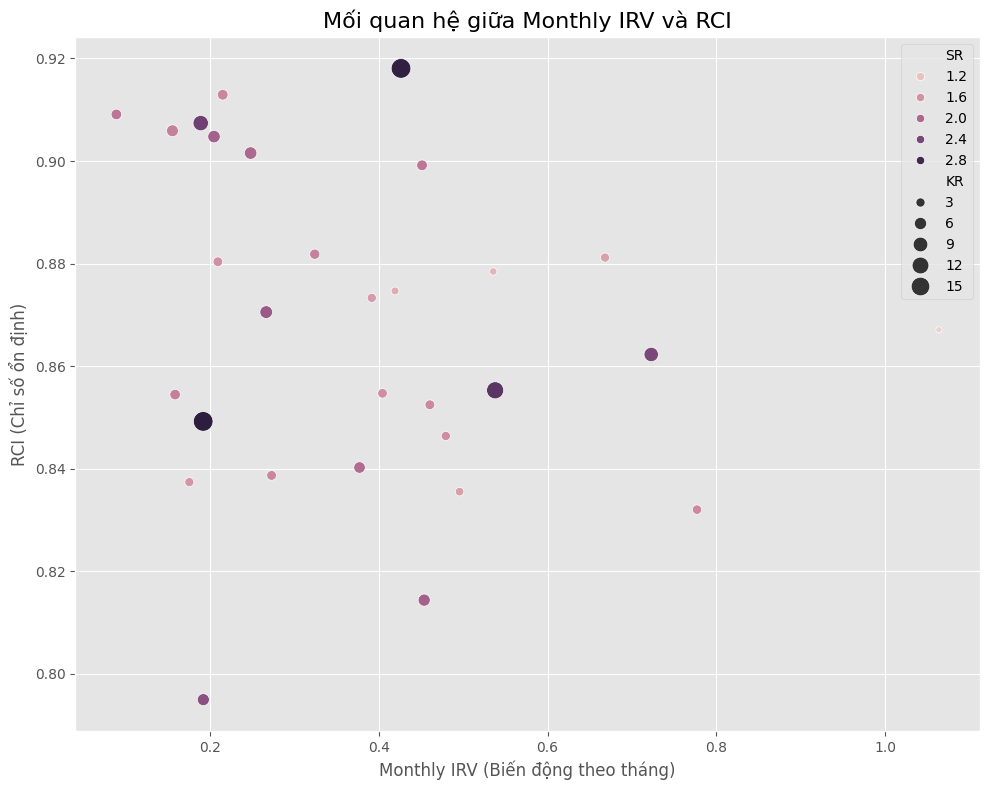

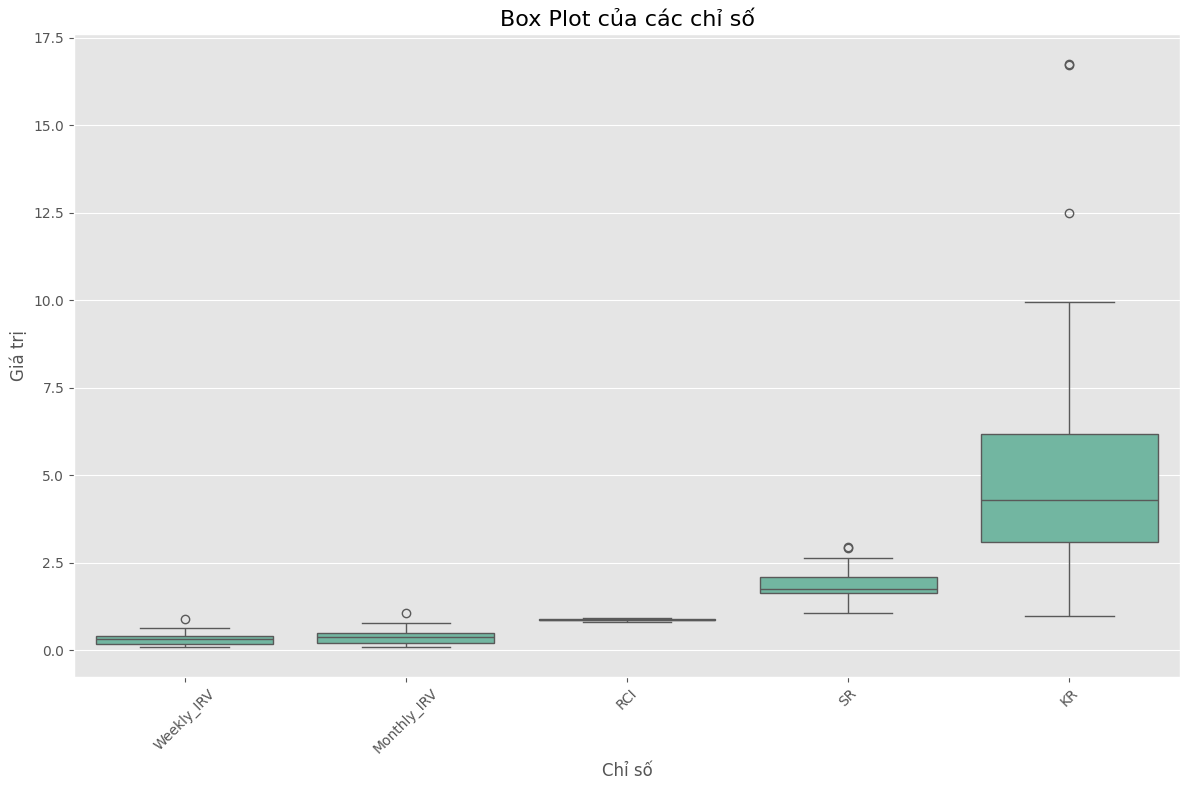

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Đọc dữ liệu từ file đã tạo
df = pd.read_csv('stock_metrics.csv')

# Thiết lập style cho biểu đồ
plt.style.use('ggplot')
sns.set_palette("Set2")

# 1. HISTOGRAM CHO CÁC CHỈ SỐ CHÍNH

# Tạo một figure với 6 subplots cho từng chỉ số
fig = plt.figure(figsize=(18, 14))
gs = GridSpec(3, 2, figure=fig)

# 1.1 Monthly IRV (Biến động theo tháng - chỉ số quan trọng nhất)
ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(df['Monthly_IRV'], bins=10, kde=True, ax=ax1)
ax1.set_title('Phân bố Monthly IRV (Biến động theo tháng)', fontsize=14)
ax1.set_xlabel('Giá trị Monthly IRV')
ax1.axvline(df['Monthly_IRV'].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Trung bình: {df["Monthly_IRV"].mean():.4f}')
ax1.legend()

# 1.2 Weekly IRV
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(df['Weekly_IRV'], bins=10, kde=True, ax=ax2)
ax2.set_title('Phân bố Weekly IRV (Biến động theo tuần)', fontsize=14)
ax2.set_xlabel('Giá trị Weekly IRV')
ax2.axvline(df['Weekly_IRV'].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Trung bình: {df["Weekly_IRV"].mean():.4f}')
ax2.legend()

# 1.3 RCI (Chỉ số ổn định)
ax3 = fig.add_subplot(gs[1, 0])
sns.histplot(df['RCI'], bins=10, kde=True, ax=ax3)
ax3.set_title('Phân bố RCI (Chỉ số ổn định dao động)', fontsize=14)
ax3.set_xlabel('Giá trị RCI')
ax3.axvline(df['RCI'].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Trung bình: {df["RCI"].mean():.4f}')
ax3.legend()

# 1.4 SR (Độ méo)
ax4 = fig.add_subplot(gs[1, 1])
sns.histplot(df['SR'], bins=10, kde=True, ax=ax4)
ax4.set_title('Phân bố SR (Độ méo của phân phối)', fontsize=14)
ax4.set_xlabel('Giá trị SR')
ax4.axvline(df['SR'].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Trung bình: {df["SR"].mean():.4f}')
ax4.legend()

# 1.5 KR (Độ nhọn)
ax5 = fig.add_subplot(gs[2, 0])
sns.histplot(df['KR'], bins=10, kde=True, ax=ax5)
ax5.set_title('Phân bố KR (Độ nhọn của phân phối)', fontsize=14)
ax5.set_xlabel('Giá trị KR')
ax5.axvline(df['KR'].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Trung bình: {df["KR"].mean():.4f}')
ax5.legend()

# 2. SO SÁNH TOP CÔNG TY THEO MONTHLY IRV
ax6 = fig.add_subplot(gs[2, 1])
top_monthly_irv = df.sort_values('Monthly_IRV', ascending=False).head(10)
sns.barplot(x='Monthly_IRV', y='company', data=top_monthly_irv, ax=ax6)
ax6.set_title('Top 10 công ty có Monthly IRV cao nhất', fontsize=14)
ax6.set_xlabel('Monthly IRV')
ax6.set_ylabel('Mã công ty')

plt.tight_layout()

# 3. BIỂU ĐỒ NHIỆT (HEATMAP) CHO TẤT CẢ CÁC CHỈ SỐ
plt.figure(figsize=(12, 10))

# Chọn các cột số để trực quan hóa
numeric_cols = ['Weekly_IRV', 'Monthly_IRV', 'RCI', 'SR', 'KR']
data_for_heatmap = df.set_index('company')[numeric_cols]

# Chuẩn hóa dữ liệu để so sánh các chỉ số khác nhau
normalized_data = (data_for_heatmap - data_for_heatmap.mean()) / data_for_heatmap.std()

# Vẽ heatmap
sns.heatmap(normalized_data, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Biểu đồ nhiệt của các chỉ số (đã chuẩn hóa)', fontsize=16)
plt.tight_layout()

# 4. BIỂU ĐỒ PHÂN TÁN (SCATTER PLOT) GIỮA MONTHLY IRV VÀ RCI
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Monthly_IRV', y='RCI', hue='SR', size='KR', sizes=(20, 200), data=df)
plt.title('Mối quan hệ giữa Monthly IRV và RCI', fontsize=16)
plt.xlabel('Monthly IRV (Biến động theo tháng)')
plt.ylabel('RCI (Chỉ số ổn định)')
plt.grid(True)
plt.tight_layout()

# 5. BOX PLOT CHO CÁC CHỈ SỐ CHÍNH
plt.figure(figsize=(12, 8))
# Tạo DataFrame mới với định dạng dài (long format) cho seaborn
long_df = pd.melt(df, id_vars=['company'], value_vars=numeric_cols, 
                  var_name='Metric', value_name='Value')

# Vẽ box plot
sns.boxplot(x='Metric', y='Value', data=long_df)
plt.title('Box Plot của các chỉ số', fontsize=16)
plt.xlabel('Chỉ số')
plt.ylabel('Giá trị')
plt.xticks(rotation=45)
plt.tight_layout()

print("Đã tạo các biểu đồ trực quan hóa!")

Số lượng công ty có đủ dữ liệu: 30 / 30


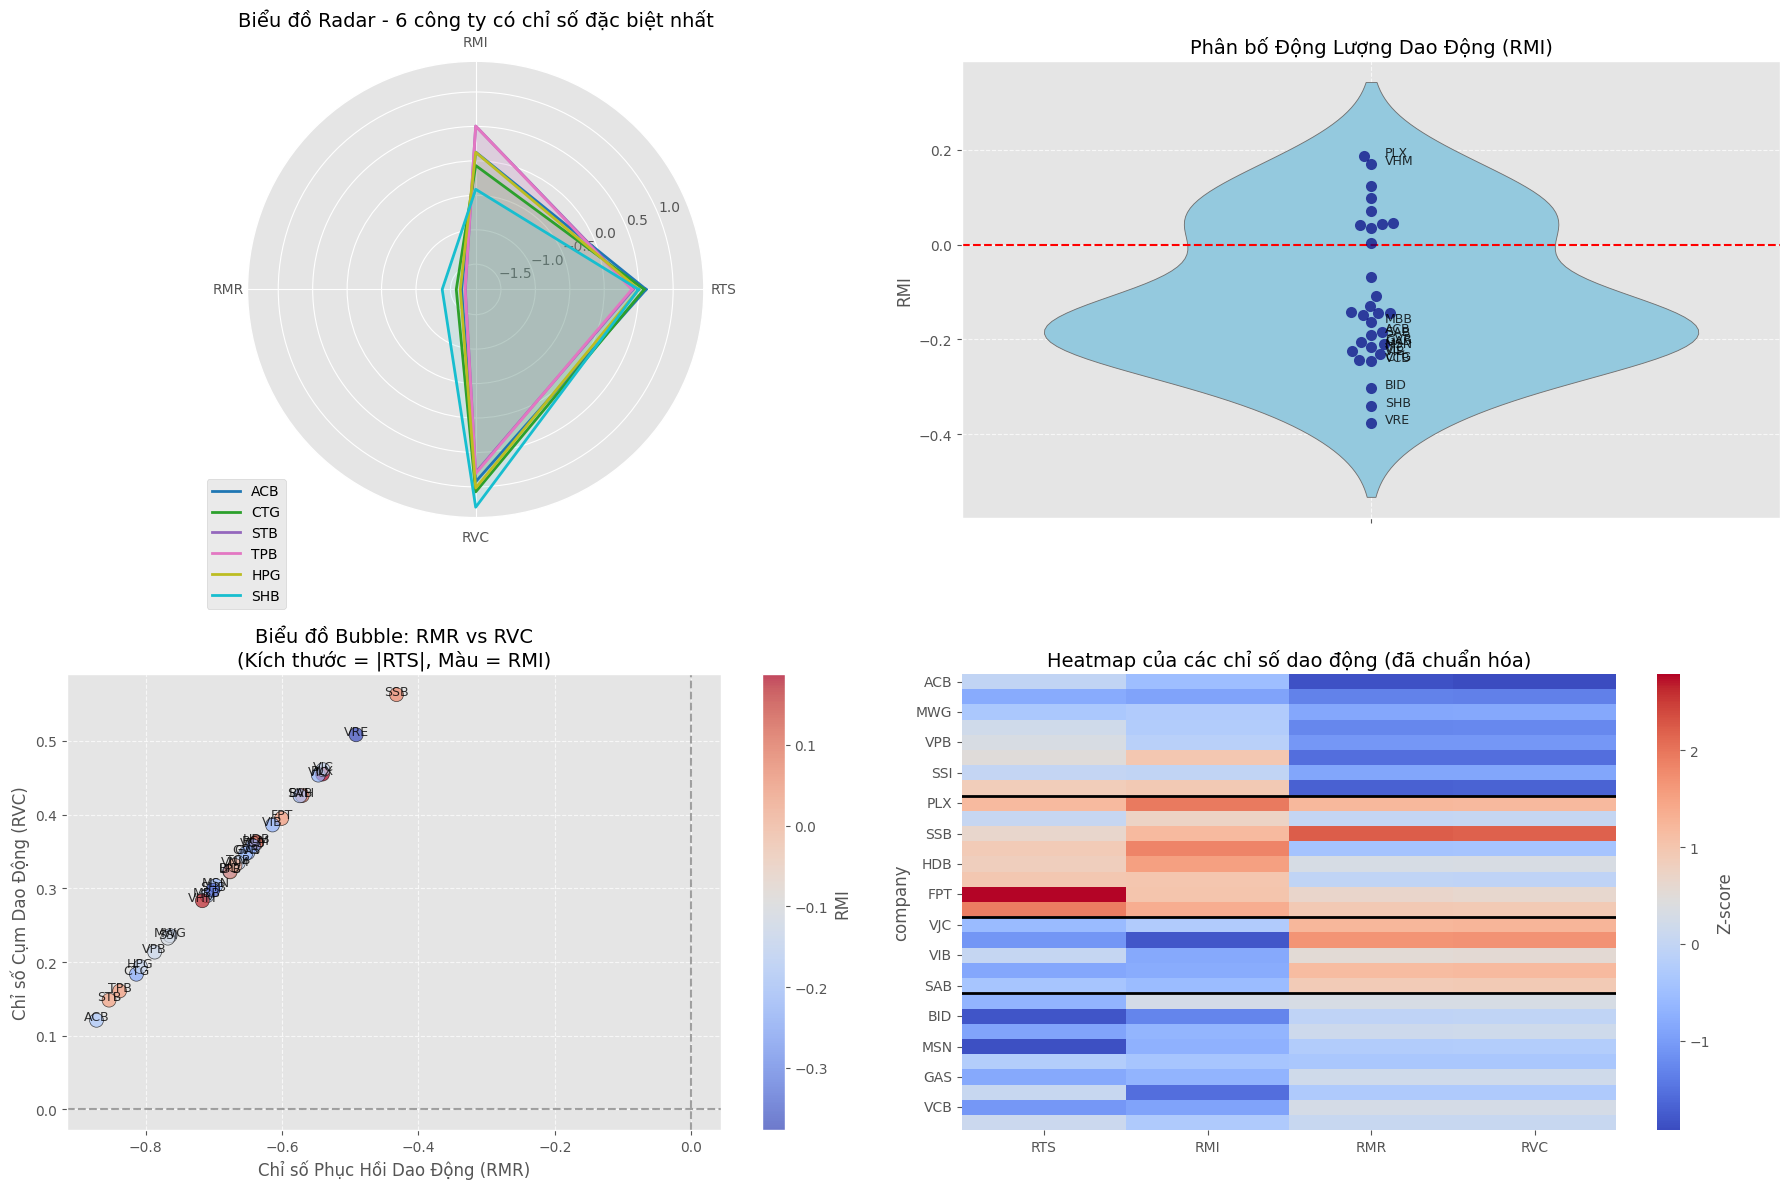

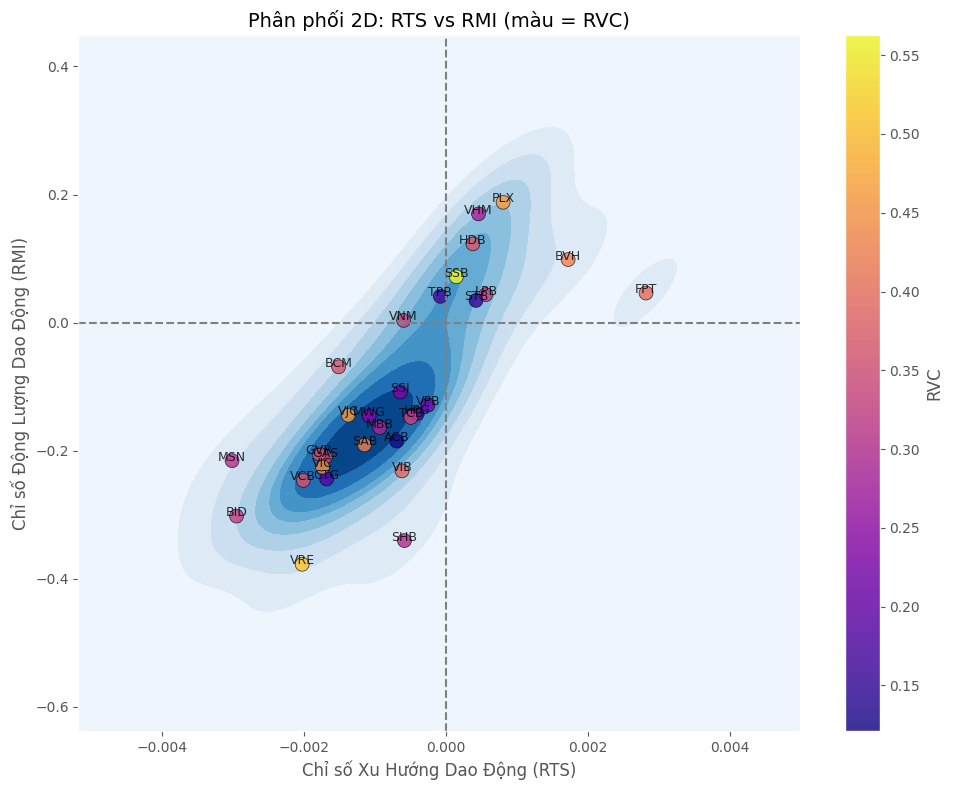


Thống kê các chỉ số:
             RTS        RMI        RMR        RVC
count  30.000000  30.000000  30.000000  30.000000
mean   -0.000664  -0.106833  -0.671644   0.327355
std     0.001272   0.153197   0.109529   0.109169
min    -0.003011  -0.377414  -0.872109   0.120979
25%    -0.001636  -0.214053  -0.752461   0.247607
50%    -0.000628  -0.145070  -0.666646   0.332644
75%     0.000093   0.039436  -0.604086   0.392515
max     0.002822   0.187925  -0.432245   0.562568

Top 5 công ty có RTS cao nhất (xu hướng tăng biến động):
   company       RTS
5      FPT  0.002822
3      BVH  0.001725
14     PLX  0.000808
10     LPB  0.000565
23     VHM  0.000462

Top 5 công ty có RMI cao nhất (động lượng tăng):
   company       RMI
14     PLX  0.187925
23     VHM  0.169783
8      HDB  0.122997
3      BVH  0.098431
17     SSB  0.071611

Top 5 công ty có RMR cao nhất (phục hồi nhanh):
   company       RMR
17     SSB -0.432245
29     VRE -0.491496
26     VJC -0.539873
14     PLX -0.540705
25     VIC -0.

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import acf
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
import warnings
warnings.filterwarnings('ignore')

# Lấy danh sách các công ty (tất cả các cột trừ cột 'time')
companies = [col for col in high_df.columns if col != 'time']

# Chuyển đổi cột time sang định dạng datetime
time_datetime = pd.to_datetime(high_df['time'])

# Khởi tạo dictionary để lưu kết quả
results = {'company': companies}
rts_list = []  # Range Trend Slope
rmi_list = []  # Range Momentum Index
rmr_list = []  # Range Mean Reversion
rvc_list = []  # Range Volatility Clustering

# Xử lý từng công ty
for company in companies:
    # Tính Chỉ số Dao Động Nội Ngày (IR): giá cao - giá thấp
    IR = high_df[company] - low_df[company]
    
    # Tạo DataFrame với thời gian và IR
    ir_df = pd.DataFrame({'time': time_datetime, 'IR': IR})
    
    # Loại bỏ các giá trị NaN
    ir_df_clean = ir_df.dropna(subset=['IR'])
    
    # 1. Chỉ số Xu Hướng Dao Động (RTS)
    # Tạo biến X là số thứ tự ngày (0, 1, 2, ...)
    if len(ir_df_clean) > 1:
        X = np.arange(len(ir_df_clean)).reshape(-1, 1)
        y = ir_df_clean['IR'].values
        
        # Kiểm tra NaN trước khi fit
        if not np.isnan(y).any():
            # Fit mô hình hồi quy tuyến tính
            model = LinearRegression()
            model.fit(X, y)
            
            # Lấy hệ số góc
            RTS = model.coef_[0]
        else:
            RTS = np.nan
    else:
        RTS = np.nan
        
    rts_list.append(RTS)
    
    # 2. Chỉ số Động Lượng Dao Động (RMI)
    # Chia dữ liệu thành nửa đầu và nửa cuối
    if len(ir_df_clean) > 1:
        half_point = len(ir_df_clean) // 2
        first_half = ir_df_clean.iloc[:half_point]
        second_half = ir_df_clean.iloc[half_point:]
        
        # Tính IR trung bình cho từng nửa
        first_half_avg = first_half['IR'].mean()
        second_half_avg = second_half['IR'].mean()
        
        # Tính RMI
        if first_half_avg != 0 and not np.isnan(first_half_avg) and not np.isnan(second_half_avg):
            RMI = second_half_avg / first_half_avg - 1
        else:
            RMI = np.nan
    else:
        RMI = np.nan
        
    rmi_list.append(RMI)
    
    # 3. Chỉ số Phục Hồi Dao Động (RMR)
    # Tạo cột lag 1 để tính sự thay đổi hàng ngày
    ir_df_clean['IR_lag'] = ir_df_clean['IR'].shift(1)
    ir_df_clean['IR_diff'] = ir_df_clean['IR'] - ir_df_clean['IR_lag']
    
    # Lọc lại để loại bỏ NaN từ phép shift
    ir_df_clean = ir_df_clean.dropna(subset=['IR_diff', 'IR'])
    
    # Tính hệ số hồi quy giữa IR và IR_diff (hệ số phục hồi)
    if len(ir_df_clean) > 1:
        X = ir_df_clean['IR'].values.reshape(-1, 1)
        y = ir_df_clean['IR_diff'].values
        
        # Kiểm tra NaN trước khi fit
        if not np.isnan(X).any() and not np.isnan(y).any():
            model = LinearRegression()
            model.fit(X, y)
            RMR = -model.coef_[0]  # Lấy hệ số âm để phản ánh mức độ hồi về trung bình
        else:
            RMR = np.nan
    else:
        RMR = np.nan
    
    rmr_list.append(RMR)
    
    # 4. Chỉ số Cụm Dao Động (RVC)
    # Tính hệ số tự tương quan bậc 1
    if len(ir_df_clean) > 1:
        try:
            ir_autocorr = acf(ir_df_clean['IR'], nlags=1)[1]  # Lấy giá trị tự tương quan bậc 1
        except:
            ir_autocorr = np.nan
    else:
        ir_autocorr = np.nan
    
    rvc_list.append(ir_autocorr)

# Thêm các chỉ số vào kết quả
results['RTS'] = rts_list
results['RMI'] = rmi_list
results['RMR'] = rmr_list
results['RVC'] = rvc_list

# Tạo DataFrame từ kết quả
results_df = pd.DataFrame(results)

# Loại bỏ các hàng có giá trị NaN
results_df = results_df.dropna()

# In thông tin về số lượng công ty còn lại sau khi loại bỏ NaN
print(f"Số lượng công ty có đủ dữ liệu: {len(results_df)} / {len(companies)}")

# Trực quan hóa kết quả bằng các loại biểu đồ mới
plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# 1. Biểu đồ Radar cho các công ty có giá trị đặc biệt
ax1 = plt.subplot(gs[0, 0], polar=True)

# Chọn 6 công ty có tổng bình phương 4 chỉ số cao nhất
results_df['sum_squared'] = (results_df['RTS']**2 + results_df['RMI']**2 + 
                            results_df['RMR']**2 + results_df['RVC']**2)
top_companies = results_df.sort_values('sum_squared', ascending=False).head(6)

# Chuẩn hóa dữ liệu để vẽ radar chart
categories = ['RTS', 'RMI', 'RMR', 'RVC']
N = len(categories)

# Góc cho mỗi trục
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Đóng vòng tròn

# Vẽ biểu đồ radar cho từng công ty
colors = plt.cm.tab10(np.linspace(0, 1, len(top_companies)))
for i, (idx, row) in enumerate(top_companies.iterrows()):
    values = [row['RTS'], row['RMI'], row['RMR'], row['RVC']]
    
    # Chuẩn hóa giá trị để hiển thị trên biểu đồ radar
    scaler = StandardScaler()
    values_scaled = scaler.fit_transform(np.array(values).reshape(-1, 1)).flatten()
    
    # Đóng vòng tròn
    values_scaled = np.append(values_scaled, values_scaled[0])
    
    # Vẽ biểu đồ
    ax1.plot(angles, values_scaled, linewidth=2, linestyle='solid', label=row['company'], color=colors[i])
    ax1.fill(angles, values_scaled, alpha=0.1, color=colors[i])

# Đặt tên cho các trục
ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(categories)

# Thêm tiêu đề và legend
ax1.set_title('Biểu đồ Radar - 6 công ty có chỉ số đặc biệt nhất', fontsize=14)
ax1.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# 2. Biểu đồ Violin kết hợp Swarm cho RMI (Động Lượng Dao Động)
ax2 = plt.subplot(gs[0, 1])
sns.violinplot(y=results_df['RMI'], ax=ax2, color="skyblue", inner=None)
sns.swarmplot(y=results_df['RMI'], ax=ax2, color="navy", size=8, alpha=0.7)

# Thêm nhãn công ty cho các điểm đặc biệt
extreme_rmi = results_df[abs(results_df['RMI']) > results_df['RMI'].std()]
for idx, row in extreme_rmi.iterrows():
    ax2.annotate(row['company'], (0, row['RMI']), xytext=(10, 0), 
                textcoords='offset points', fontsize=9, alpha=0.8)

ax2.set_title('Phân bố Động Lượng Dao Động (RMI)', fontsize=14)
ax2.set_ylabel('RMI')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.axhline(y=0, color='red', linestyle='--')

# 3. Biểu đồ Bubble cho RMR vs RVC với kích thước RTS và màu RMI
ax3 = plt.subplot(gs[1, 0])
scatter = ax3.scatter(results_df['RMR'], results_df['RVC'], 
                     s=abs(results_df['RTS'])*1000 + 100,  # Kích thước dựa trên |RTS|
                     c=results_df['RMI'], cmap='coolwarm', 
                     alpha=0.7, edgecolors='black')

# Thêm nhãn cho các điểm
for idx, row in results_df.iterrows():
    ax3.annotate(row['company'], (row['RMR'], row['RVC']), 
                fontsize=9, alpha=0.8, ha='center')

ax3.set_xlabel('Chỉ số Phục Hồi Dao Động (RMR)')
ax3.set_ylabel('Chỉ số Cụm Dao Động (RVC)')
ax3.set_title('Biểu đồ Bubble: RMR vs RVC\n(Kích thước = |RTS|, Màu = RMI)', fontsize=14)
plt.colorbar(scatter, label='RMI')
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
ax3.axvline(x=0, color='gray', linestyle='--', alpha=0.7)

# 4. Biểu đồ Heatmap kết hợp Clustermap
ax4 = plt.subplot(gs[1, 1])

# Chuẩn bị dữ liệu cho phân cụm
features = ['RTS', 'RMI', 'RMR', 'RVC']
X = results_df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Tạo DataFrame mới để vẽ heatmap
heatmap_df = pd.DataFrame(X_scaled, columns=features, index=results_df['company'])

# Phân cụm
n_clusters = min(4, len(heatmap_df))  # Đảm bảo số cụm không vượt quá số công ty
if len(heatmap_df) >= n_clusters:
    try:
        # Phân cụm và sắp xếp lại DataFrame
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        heatmap_df['cluster'] = kmeans.fit_predict(X_scaled)
        
        # Sắp xếp theo cụm để vẽ heatmap
        heatmap_df = heatmap_df.sort_values('cluster')
        
        # Vẽ heatmap
        sns.heatmap(heatmap_df[features], cmap='coolwarm', ax=ax4, 
                   cbar_kws={'label': 'Z-score'})
        
        # Thêm đường phân chia giữa các cụm
        cluster_counts = heatmap_df['cluster'].value_counts().sort_index()
        cluster_edges = np.cumsum(cluster_counts)[:-1]
        for edge in cluster_edges:
            ax4.axhline(y=edge, color='black', linestyle='-', linewidth=2)
    except:
        # Nếu phân cụm gặp lỗi, vẽ heatmap đơn giản
        sns.heatmap(heatmap_df[features], cmap='coolwarm', ax=ax4, 
                   cbar_kws={'label': 'Z-score'})
else:
    # Nếu quá ít công ty, vẽ heatmap đơn giản
    sns.heatmap(heatmap_df[features], cmap='coolwarm', ax=ax4, 
               cbar_kws={'label': 'Z-score'})

ax4.set_title('Heatmap của các chỉ số dao động (đã chuẩn hóa)', fontsize=14)

plt.tight_layout()
plt.show()

# 5. Biểu đồ Phân phối 2D cho RTS và RMI
plt.figure(figsize=(10, 8))
sns.kdeplot(x=results_df['RTS'], y=results_df['RMI'], cmap="Blues", fill=True, thresh=0)
scatter = plt.scatter(results_df['RTS'], results_df['RMI'], 
                     c=results_df['RVC'], cmap='plasma', 
                     s=100, edgecolor='black', alpha=0.8)

# Thêm nhãn cho các điểm
for idx, row in results_df.iterrows():
    plt.annotate(row['company'], (row['RTS'], row['RMI']), 
                fontsize=9, alpha=0.8, ha='center')

plt.xlabel('Chỉ số Xu Hướng Dao Động (RTS)')
plt.ylabel('Chỉ số Động Lượng Dao Động (RMI)')
plt.title('Phân phối 2D: RTS vs RMI (màu = RVC)', fontsize=14)
plt.colorbar(scatter, label='RVC')
plt.grid(True, linestyle='--', alpha=0.3)
plt.axhline(y=0, color='gray', linestyle='--')
plt.axvline(x=0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

# Lưu kết quả vào file CSV
results_df.to_csv('range_metrics_advanced.csv', index=False)

# In thông tin thống kê cho từng chỉ số
print("\nThống kê các chỉ số:")
print(results_df[features].describe())

# In các công ty với các chỉ số đặc biệt
print("\nTop 5 công ty có RTS cao nhất (xu hướng tăng biến động):")
print(results_df.sort_values('RTS', ascending=False).head(5)[['company', 'RTS']])

print("\nTop 5 công ty có RMI cao nhất (động lượng tăng):")
print(results_df.sort_values('RMI', ascending=False).head(5)[['company', 'RMI']])

print("\nTop 5 công ty có RMR cao nhất (phục hồi nhanh):")
print(results_df.sort_values('RMR', ascending=False).head(5)[['company', 'RMR']])

print("\nTop 5 công ty có RVC cao nhất (cụm biến động):")
print(results_df.sort_values('RVC', ascending=False).head(5)[['company', 'RVC']])